In [36]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy import sparse
import os
from sklearn import metrics

os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
gamma_tree = uproot.open(
    "/home2/chenxu/work/corsika/50GeV_1TeV_zen0.gamma.root:tCorsika"
)
P_tree = uproot.open(
    "/home2/chenxu/work/corsika/100GeV_10TeV_zen0.proton.root:tCorsika"
)

In [4]:
gamma_prie = np.array(gamma_tree["evth/fLia[312]"].array()[:, 3])
P_prie = np.array(P_tree["evth/fLia[312]"].array()[:, 3])

In [5]:
gamma_secs = gamma_tree["secParticles/secParticles.fLia[8]"].array()
P_secs = P_tree["secParticles/secParticles.fLia[8]"].array()

In [6]:
secs = list()
nparticle = list()
for i in range(len(gamma_secs)):
    secs.append(gamma_secs[i])
    nparticle.append(len(gamma_secs[i]))
for i in range(len(gamma_secs)):
    secs.append(P_secs[i])
    nparticle.append(len(P_secs[i]))
secs = np.array(secs, dtype=object)
nparticle = np.array(nparticle)

In [7]:
sectype = list()
for i in range(100000):
    sectype.append(np.floor(np.array(gamma_secs[i])[:, 0] / 1000).astype(int))
    sectype.append(np.floor(np.array(P_secs[i])[:, 0] / 1000).astype(int))
sectype = np.concatenate(sectype)
sectype = list(set(sectype))

In [ ]:
sectype

In [8]:
secstypes = [[1, 2, 3], [5, 6], [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18]]

In [ ]:
sec = np.array(P_secs[0])
sec = sec[:, :-1]
xbins = np.linspace(-500 * 100, 500 * 100, 225)
ybins = np.linspace(-500 * 100, 500 * 100, 225)
for i in sectype:
    print(i)
    H, _, _ = np.histogram2d(
        sec[:, 4][np.isin((sec[:, 0] / 1000).astype(int), i)],
        sec[:, 5][np.isin((sec[:, 0] / 1000).astype(int), i)],
        bins=(xbins, ybins),
    )
    H = H.T
    print(np.max(H))
    X, Y = np.meshgrid(xbins, ybins)
    plt.pcolormesh(X, Y, H)
    plt.show()

In [9]:
gamma_log10energy = np.log10(gamma_prie).astype(np.float32)
P_log10energy = np.log10(P_prie).astype(np.float32)
log10energy = np.concatenate([gamma_log10energy, P_log10energy])

In [10]:
isgamma = np.zeros_like(log10energy, dtype=int)
isgamma[: len(gamma_log10energy)] = 1

In [43]:
class MCDataset_dgl(DGLDataset):
    def __init__(self, isgamma, secs):
        self.secs = secs
        self.isgamma = isgamma
        self.secstypes = [
            [1, 2, 3],
            [5, 6],
            [8, 9, 13, 14, 15, 25, 10, 11, 12, 201, 18],
        ]
        self.xmax = 50 * 100
        self.ymax = 50 * 100
        self.enc = OneHotEncoder()
        self.enc.fit(np.arange(3).reshape(-1, 1))
        super().__init__(name="corsika_data")

    def process(self):
        self.graphs = list()
        self.isgamma_need = list()
        seccount = 0
        for secs in tqdm(self.secs, mininterval=1):
            secs = np.array(secs)
            secs = secs[
                np.where(
                    (np.abs(secs[:, 4]) < self.xmax) & (np.abs(secs[:, 5]) < self.ymax)
                )
            ]
            secslen = len(secs)
            if secslen < 30:
                seccount += 1
                continue
            #             print(secslen)
            self.isgamma_need.append(self.isgamma[seccount])
            seccount += 1
            secstype_new = 0
            for secstype in self.secstypes:
                secs[:, 0][
                    np.isin((secs[:, 0] / 1000).astype(int), secstype)
                ] = secstype_new
                secstype_new += 1

            xdata = np.zeros([secslen, 9], dtype=np.float32)
            xdata[:, :3] = self.enc.transform(secs[:, 0].reshape(-1, 1)).toarray()
            xdata[:, 3:6] = secs[:, 1:4]
            xdata[:, 6:8] = secs[:, 4:6] / self.xmax
            xdata[:, 8] = (secs[:, 6] - np.mean(secs[:, 6])) * 30 / self.xmax
            src = np.array([n for n in range(secslen) for _ in range(secslen)],dtype=np.int32)
            dst = np.array(list(range(secslen))*secslen,dtype=np.int32)
            need_del = np.where(src==dst)
            src = np.delete(src,need_del[0])
            dst = np.delete(dst,need_del[0])
            src = torch.tensor(src)
            dst = torch.tensor(dst)

#             print(src.shape)
            g = dgl.graph((src, dst), num_nodes=secslen)
            g.ndata["xdata"] = torch.from_numpy(xdata)
            self.graphs.append(g)
        self.isgamma_need = torch.tensor(self.isgamma_need,dtype=torch.long)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, index):
        return (
            self.graphs[index],
            self.isgamma_need[index],
        )

In [32]:
train_val_index, test__index = train_test_split(
    range(len(isgamma)), random_state=42, test_size=0.3
)
train_index, val_index = train_test_split(
    train_val_index, random_state=42, test_size=0.3
)

In [33]:
MCdataset_train = MCDataset_dgl(isgamma[train_index], secs[train_index])
MCdataset_val = MCDataset_dgl(isgamma[val_index], secs[val_index])

  0%|          | 0/98000 [00:00<?, ?it/s]

  0%|          | 0/42000 [00:00<?, ?it/s]

In [55]:
savepath = "/tmp/hky/gnndata_gin_Pgamma/train_data/"
dgl.save_graphs(os.path.join(savepath,f"graph.bin"),MCdataset_train.graphs)
np.save(os.path.join(savepath,f"label.npy"),MCdataset_train.isgamma_need)

In [ ]:
savepath = "/tmp/hky/gnndata_gin_Pgamma/val_data/"
dgl.save_graphs(os.path.join(savepath,f"graph.bin"),MCdataset_val.graphs)
np.save(os.path.join(savepath,f"label.npy"),MCdataset_val.isgamma_need)

In [53]:
len(MCdataset_train.isgamma_need)

32945

In [34]:
train_dataloader = GraphDataLoader(MCdataset_train, batch_size=64, drop_last=False)
val_dataloader = GraphDataLoader(MCdataset_val, batch_size=64, drop_last=False)

In [35]:
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling


class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            MaxPooling()
        )  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer

In [51]:
model = GIN(9, 64, 2).to(device)
maxtpoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, maxtpoch, eta_min=1e-5
)
for epoch in range(maxtpoch):
    sumloss = list()
    print(epoch)
    for batched_graph, labels in train_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        sumloss.append(loss.item())
        optimizer.step()
    lr_scheduler.step()
    print(f"loss:{np.mean(sumloss):.4f}")
    model.eval()
    count1 = 0
    count2 = 0
    m = nn.Softmax(dim=1)
    y_pred = list()
    y_orgin = list()
    with torch.no_grad():
        for batched_graph, labels in val_dataloader:
            batched_graph, labels = batched_graph.to(device), labels.to(device)
            pred = model(batched_graph, batched_graph.ndata["xdata"])
            pred = m(pred)
            y_pred.append(pred[:, 1].cpu().numpy())
            y_orgin.append(labels.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    y_orgin = np.concatenate(y_orgin)
    auc = metrics.roc_auc_score(y_orgin, y_pred)
    print(f"auc:{auc:.4f}")

0
loss:0.5153


DGLError: [16:19:30] /opt/dgl/src/runtime/cuda/cuda_device_api.cc:117: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading: CUDA: out of memory
Stack trace:
  [bt] (0) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(+0x8b9655) [0x7facd274e655]
  [bt] (1) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::runtime::CUDADeviceAPI::AllocDataSpace(DGLContext, unsigned long, unsigned long, DGLDataType)+0x17d) [0x7facd274ffbd]
  [bt] (2) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::runtime::NDArray::Empty(std::vector<long, std::allocator<long> >, DGLDataType, DGLContext)+0x170) [0x7facd25c79b0]
  [bt] (3) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::aten::NewIdArray(long, DGLContext, unsigned char)+0x6d) [0x7facd21cc05d]
  [bt] (4) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(std::pair<dgl::runtime::NDArray, dgl::runtime::NDArray> dgl::aten::impl::Sort<(DGLDeviceType)2, int>(dgl::runtime::NDArray, int)+0x6b) [0x7facd2776c7b]
  [bt] (5) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::aten::Sort(dgl::runtime::NDArray, int)+0x492) [0x7facd21e33d2]
  [bt] (6) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(void dgl::aten::impl::COOSort_<(DGLDeviceType)2, int>(dgl::aten::COOMatrix*, bool)+0x394) [0x7facd277f8e4]
  [bt] (7) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::aten::COOSort_(dgl::aten::COOMatrix*, bool)+0x354) [0x7facd21d87b4]
  [bt] (8) /home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/libdgl.so(dgl::aten::COOSort(dgl::aten::COOMatrix, bool)+0x530) [0x7facd277e030]



In [20]:
model.eval()
count1 = 0
count2 = 0
m = nn.Softmax(dim=1)
y_pred = list()
y_orgin = list()
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        pred = m(pred)
        y_pred.append(pred[:, 1].cpu().numpy())
        y_orgin.append(labels.cpu().numpy())

In [21]:
y_pred = np.concatenate(y_pred)
y_orgin = np.concatenate(y_orgin)

(0.0, 0.3)

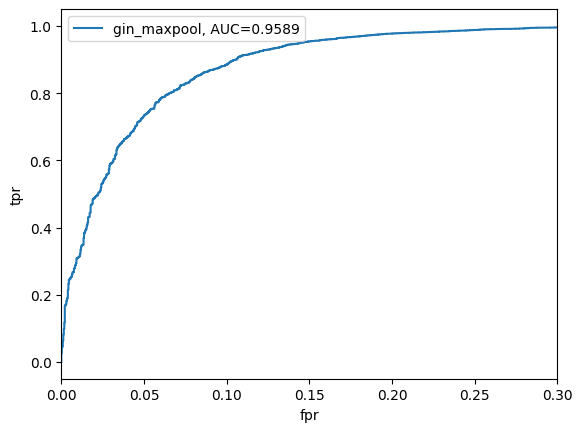

In [23]:

fpr_maxpool, tpr_maxpool, _ = metrics.roc_curve(y_orgin, y_pred)
auc = metrics.roc_auc_score(y_orgin, y_pred)
plt.plot(fpr_maxpool, tpr_maxpool, label=f"gin_maxpool, AUC={auc:.4f}")
plt.xlabel("fpr")
plt.ylabel("tpr ")
plt.legend()
plt.xlim(0, 0.3)

In [24]:
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling


class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN_avg(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            AvgPooling()
        )  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer

In [25]:
model = GIN_avg(9, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for epoch in range(100):
    sumloss = list()
    print(epoch)
    for batched_graph, labels in train_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        sumloss.append(loss.item())
        optimizer.step()
    print(f"loss:{np.mean(sumloss):.4f}")

0
loss:0.4324
1
loss:0.3706
2
loss:0.3502
3
loss:0.3443
4
loss:0.3329
5
loss:0.3246
6
loss:0.3279
7
loss:0.3191
8
loss:0.3172
9
loss:0.3073
10
loss:0.3056
11
loss:0.3079
12
loss:0.3047
13
loss:0.3003
14
loss:0.2918
15
loss:0.2909
16
loss:0.2884
17
loss:0.2810
18
loss:0.2816
19
loss:0.2813
20
loss:0.2861
21
loss:0.2830
22
loss:0.2765
23
loss:0.2739
24
loss:0.2898
25
loss:0.2817
26
loss:0.2743
27
loss:0.2746
28
loss:0.2709
29
loss:0.2706
30
loss:0.2723
31
loss:0.2707
32
loss:0.2713
33
loss:0.2653
34
loss:0.2675
35
loss:0.2676
36
loss:0.2712
37
loss:0.2656
38
loss:0.2637
39
loss:0.2604
40
loss:0.2668
41
loss:0.2594
42
loss:0.2620
43
loss:0.2619
44
loss:0.2612
45
loss:0.2622
46
loss:0.2570
47
loss:0.2582
48
loss:0.2572
49
loss:0.2570
50
loss:0.2542
51
loss:0.2766
52
loss:0.2741
53
loss:0.2662
54
loss:0.2652
55
loss:0.2625
56
loss:0.2599
57
loss:0.2587
58
loss:0.2568
59
loss:0.2583
60
loss:0.2601
61
loss:0.2539
62
loss:0.2525
63
loss:0.2533
64
loss:0.2548
65
loss:0.2516
66
loss:0.2491
67
lo

In [26]:
model.eval()
count1 = 0
count2 = 0
m = nn.Softmax(dim=1)
y_pred = list()
y_orgin = list()
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        pred = m(pred)
        y_pred.append(pred[:, 1].cpu().numpy())
        y_orgin.append(labels.cpu().numpy())
y_pred = np.concatenate(y_pred)
y_orgin = np.concatenate(y_orgin)

(0.0, 0.3)

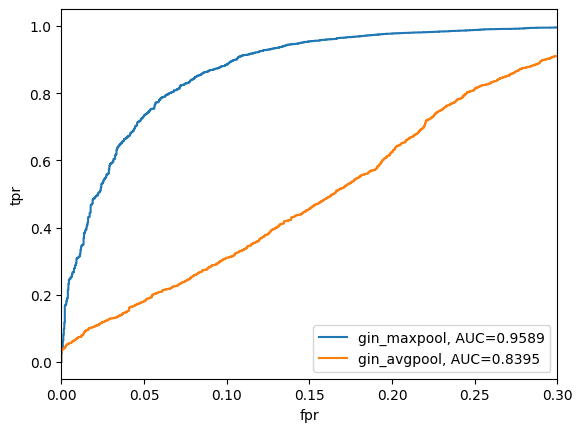

In [30]:
from sklearn import metrics

fpr_avgpool, tpr_avgpool, _ = metrics.roc_curve(y_orgin, y_pred)
auc_avg = metrics.roc_auc_score(y_orgin, y_pred)
plt.plot(fpr_maxpool, tpr_maxpool, label=f"gin_maxpool, AUC={auc:.4f}")
plt.plot(fpr_avgpool, tpr_avgpool, label=f"gin_avgpool, AUC={auc_avg:.4f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.xlim(0, 0.3)

In [61]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class MLP(nn.Sequential):
    r"""

    Description
    -----------
    From equation (5) in "DeeperGCN: All You Need to Train Deeper GCNs <https://arxiv.org/abs/2006.07739>"
    """

    def __init__(self, channels, act="relu", dropout=0.0, bias=True):
        layers = []

        for i in range(1, len(channels)):
            layers.append(nn.Linear(channels[i - 1], channels[i], bias))
            if i < len(channels) - 1:
                layers.append(nn.BatchNorm1d(channels[i], affine=True))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))

        super(MLP, self).__init__(*layers)


class MessageNorm(nn.Module):
    r"""

    Description
    -----------
    Message normalization was introduced in "DeeperGCN: All You Need to Train Deeper GCNs <https://arxiv.org/abs/2006.07739>"

    Parameters
    ----------
    learn_scale: bool
        Whether s is a learnable scaling factor or not. Default is False.
    """

    def __init__(self, learn_scale=False):
        super(MessageNorm, self).__init__()
        self.scale = nn.Parameter(torch.FloatTensor([1.0]), requires_grad=learn_scale)

    def forward(self, feats, msg, p=2):
        msg = F.normalize(msg, p=2, dim=-1)
        feats_norm = feats.norm(p=p, dim=-1, keepdim=True)
        return msg * feats_norm * self.scale


class GENConv(nn.Module):
    r"""

    Description
    -----------
    Generalized Message Aggregator was introduced in "DeeperGCN: All You Need to Train Deeper GCNs <https://arxiv.org/abs/2006.07739>"

    Parameters
    ----------
    in_dim: int
        Input size.
    out_dim: int
        Output size.
    aggregator: str
        Type of aggregation. Default is 'softmax'.
    beta: float
        A continuous variable called an inverse temperature. Default is 1.0.
    learn_beta: bool
        Whether beta is a learnable variable or not. Default is False.
    p: float
        Initial power for power mean aggregation. Default is 1.0.
    learn_p: bool
        Whether p is a learnable variable or not. Default is False.
    msg_norm: bool
        Whether message normalization is used. Default is False.
    learn_msg_scale: bool
        Whether s is a learnable scaling factor or not in message normalization. Default is False.
    mlp_layers: int
        The number of MLP layers. Default is 1.
    eps: float
        A small positive constant in message construction function. Default is 1e-7.
    """

    def __init__(
        self,
        in_dim,
        out_dim,
        aggregator="softmax",
        beta=1.0,
        learn_beta=False,
        p=1.0,
        learn_p=False,
        msg_norm=False,
        learn_msg_scale=False,
        mlp_layers=1,
        eps=1e-7,
    ):
        super(GENConv, self).__init__()

        self.aggr = aggregator
        self.eps = eps

        channels = [in_dim]
        for _ in range(mlp_layers - 1):
            channels.append(in_dim * 2)
        channels.append(out_dim)

        self.mlp = MLP(channels)
        self.msg_norm = MessageNorm(learn_msg_scale) if msg_norm else None

        self.beta = (
            nn.Parameter(torch.Tensor([beta]), requires_grad=True)
            if learn_beta and self.aggr == "softmax"
            else beta
        )
        self.p = nn.Parameter(torch.Tensor([p]), requires_grad=True) if learn_p else p

        self.edge_encoder = BondEncoder(in_dim)

    def forward(self, g, node_feats, edge_feats):
        with g.local_scope():
            # Node and edge feature size need to match.
            g.ndata["h"] = node_feats
            g.edata["h"] = self.edge_encoder(edge_feats)
            g.apply_edges(fn.u_add_e("h", "h", "m"))

            if self.aggr == "softmax":
                g.edata["m"] = F.relu(g.edata["m"]) + self.eps
                g.edata["a"] = edge_softmax(g, g.edata["m"] * self.beta)
                g.update_all(
                    lambda edge: {"x": edge.data["m"] * edge.data["a"]},
                    fn.sum("x", "m"),
                )

            elif self.aggr == "power":
                minv, maxv = 1e-7, 1e1
                torch.clamp_(g.edata["m"], minv, maxv)
                g.update_all(
                    lambda edge: {"x": torch.pow(edge.data["m"], self.p)},
                    fn.mean("x", "m"),
                )
                torch.clamp_(g.ndata["m"], minv, maxv)
                g.ndata["m"] = torch.pow(g.ndata["m"], self.p)

            else:
                raise NotImplementedError(f"Aggregator {self.aggr} is not supported.")

            if self.msg_norm is not None:
                g.ndata["m"] = self.msg_norm(node_feats, g.ndata["m"])

            feats = node_feats + g.ndata["m"]

            return self.mlp(feats)


class DeeperGCN(nn.Module):
    r"""

    Description
    -----------
    Introduced in "DeeperGCN: All You Need to Train Deeper GCNs <https://arxiv.org/abs/2006.07739>"

    Parameters
    ----------
    node_feat_dim: int
        Size of node feature.
    edge_feat_dim: int
        Size of edge feature.
    hid_dim: int
        Size of hidden representations.
    out_dim: int
        Size of output.
    num_layers: int
        Number of graph convolutional layers.
    dropout: float
        Dropout rate. Default is 0.
    beta: float
        A continuous variable called an inverse temperature. Default is 1.0.
    learn_beta: bool
        Whether beta is a learnable weight. Default is False.
    aggr: str
        Type of aggregation. Default is 'softmax'.
    mlp_layers: int
        Number of MLP layers in message normalization. Default is 1.
    """

    def __init__(
        self,
        node_feat_dim,
        edge_feat_dim,
        hid_dim,
        out_dim,
        num_layers,
        dropout=0.0,
        beta=1.0,
        learn_beta=False,
        aggr="softmax",
        mlp_layers=1,
    ):
        super(DeeperGCN, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        self.gcns = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(self.num_layers):
            conv = GENConv(
                in_dim=hid_dim,
                out_dim=hid_dim,
                aggregator=aggr,
                beta=beta,
                learn_beta=learn_beta,
                mlp_layers=mlp_layers,
            )

            self.gcns.append(conv)
            self.norms.append(nn.BatchNorm1d(hid_dim, affine=True))

        self.node_encoder = AtomEncoder(hid_dim)
        self.pooling = AvgPooling()
        self.output = nn.Linear(hid_dim, out_dim)

    def forward(self, g, edge_feats, node_feats=None):
        with g.local_scope():
            hv = self.node_encoder(node_feats)
            he = edge_feats

            for layer in range(self.num_layers):
                hv1 = self.norms[layer](hv)
                hv1 = F.relu(hv1)
                hv1 = F.dropout(hv1, p=self.dropout, training=self.training)
                hv = self.gcns[layer](g, hv1, he) + hv

            h_g = self.pooling(g, hv)

            return self.output(h_g)

In [62]:
model = DeeperGCN(
    9,
    0,
    64,
    2,
    5,
    0.5,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
for epoch in range(100):
    sumloss = list()
    print(epoch)
    for batched_graph, labels in train_dataloader:
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        #         print(pred.shape)
        loss = F.cross_entropy(pred, labels)
        #         print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        sumloss.append(loss.item())
        optimizer.step()
    print(f"loss:{np.mean(sumloss):.4f}")

0


AttributeError: 'NoneType' object has no attribute 'shape'